# Neural Style Transfer con VGG19

## Librerie

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from PIL import Image
import time
import functools

import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

## Caricamento immagini

La prima cosa da fare è caricare le immagini di input:

- L'immagine di *contenuto*, che rappresenta la base di partenza da modificare;

- L'immagine di *stile*, che indica in che modo l'immagine di contenuto debba essere modificata.

Si effettuano inoltre tre operazioni preliminari sulle immagini:

1. Si ridimensionano le immagini a dimensioni prefissate (512x512 pixel)

2. Se l'immagine non è in formato RGB, la si converte in RGB (3 canali di colore). 
(Ad esempio, le estensioni .png sono composte da 4 canali di colore RGBA.)

3. Si aggiunge una quarta dimensione all'immagine, che rappresenta la batch dimension: ciò serve a far accettare l'immagine in input al modello VGG19. 
Si ha: (512,512,3) -> (1,512,512,3)

In [ ]:
style_img_file = 'style_img.png'
content_img_file = 'content_img.png'

In [ ]:
def load_img(path_to_img):
  img_dim = 512
  img = Image.open(path_to_img).convert('RGB')
  img = img.resize((img_dim, img_dim), Image.ANTIALIAS)

  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

def imshow(img, title=None):
  # Remove the batch dimension
  try:
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
  except:
    out = img
  # Normalize for display 
  
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)



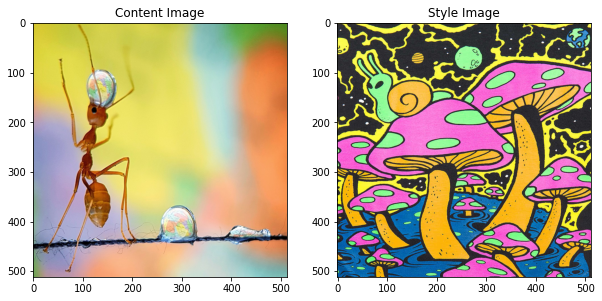

In [ ]:
plt.figure(figsize=(10,10))

content = load_img(content_img_file).astype('uint8')
style = load_img(style_img_file).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

Il prossimo step è quello di pre-processare ulteriormente le immagini, in modo da poter essere date in input al modello. Modelli diversi richiedono pre-processing diversi.

Nel caso del VGG19, le immagini vengono convertite da RGB a BGR, ed ogni canale di colore è poi centrato in zero rispetto alla media delle immagini del dataset ImageNet, usato per allenare VGG19.

In altre parole, si sottrae ai colori delle immagini la `media = [103.939, 116.779, 123.68]`. Tale vettore è indipendente dalle due immagini che diamo in input.

Nella funzione di de-processing, si impone inoltre che l'immagine generata abbia valori compresi tra o e 255 nei canali di colore (questo perchè, di base, potrebbero essere compresi tra $- \infty$ e $\infty$).



In [ ]:
########################################################################

def process_img(image):
  return tf.keras.applications.vgg19.preprocess_input(image)

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

########################################################################

Ecco le due immagini originali, processate e de-processate:

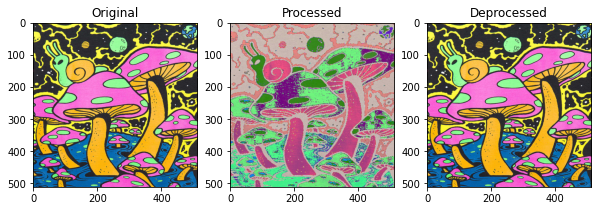

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1, 3, 1)
imshow(style,'Original')

plt.subplot(1, 3, 2)
imshow(process_img(style),'Processed')

plt.subplot(1, 3, 3)
imshow([deprocess_img(process_img(style))],'Deprocessed')

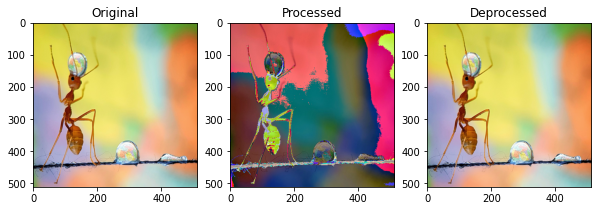

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1, 3, 1)
imshow(content,'Original')

plt.subplot(1, 3, 2)
imshow(process_img(content),'Processed')

plt.subplot(1, 3, 3)
imshow([deprocess_img(process_img(content))],'Deprocessed')

Il prossimo step consiste nello scegliere su quali layer del modello saranno calcolate le loss di stile e contenuto.

Il modello VGG19 è stato allenato su ImageNet per essere un classificatore di immagini: i suoi layer interni sono quindi stati addestrati per essere degli estrattori di features.

E' quindi ragionevole supporre che nei primi layer del modello vi sia una rappresentazione dello *stile* dell'immagine, e nei layer più profondi risieda invece il *contenuto*.

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Modello

Il modello usato è il VGG19, composto da:

- 16 layer convoluzionali, a grandezza progressivamente crescente e raggruppati in blocchi in base alla grandezza;
- 5 layer di MaxPooling, che separano i blocchi di layer convoluzionali;
- 3 layer fully-connected, con attivazione softmax sull'ultimo layer.

<div>
<center><img src = https://drive.google.com/uc?export=view&id=14g7zcFyYi5iqGj4z2YjGXUnADuNKKwZ9  width="600" height="300"/></center>
</div>



Nel Neural style transfer, il target dell'ottimizzazione è l'immagine, mentre il modello impiegato è fisso e deve essere già allenato. 
Si scarica quindi il VGG19 da Keras:

In [ ]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

L'ultimo step consiste nel definire le funzioni di style_loss e content_loss, oltre alle funzioni necessarie per il loop:

In [ ]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [ ]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

In [ ]:
def get_feature_representations(model, content_path, style_path):

  # Load our images in 
  content_image = process_img(content_path)
  style_image = process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

## Style Transfer loop

Adesso è tutto pronto per applicare il Neural Style Transfer: si definisce il loop che, ad ogni iterazione, andrà a modificare l'immagine di *contenuto* di partenza sulla base del gradiente calcolato sulle due loss function.

In [ ]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss, imgs

A titolo di esempio, ecco come viene modificata l'immagine di partenza ogni 100 iterazioni, per un totale di 1000 iterazioni:

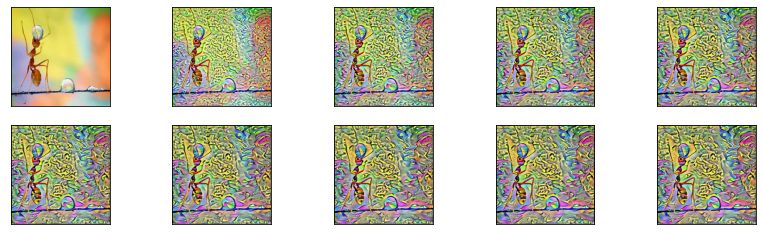

In [ ]:
best, best_loss, imgs = run_style_transfer(content, 
                                     style, num_iterations=1000)

Ed ecco il risultato finale:

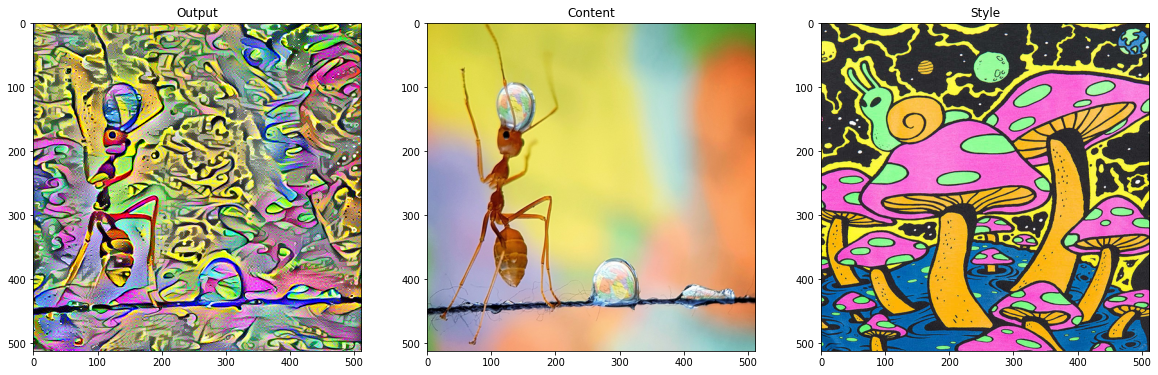

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
imshow(Image.fromarray(imgs[9]),'Output')


plt.subplot(1, 3, 2)
imshow(content,'Content')


plt.subplot(1, 3, 3)
imshow(style,'Style')

## Salvare il risultato

Se l'immagine ottenuta è soddisfacente, il Neural Style Transfer è stato eseguito con successo! Si scarica l'immagine in formato jpg.

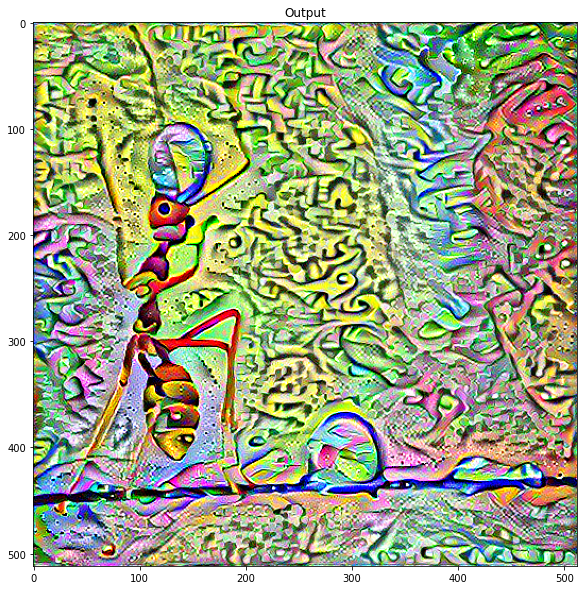

In [ ]:
Image.fromarray(imgs[9]).save('result.jpg')
plt.figure(figsize=(10,10))
imshow(Image.fromarray(imgs[2]),'Output')